In [2]:
# in terminal
'''
mongoimport --type json -d texasSchoolsDB -c scores_finances --drop --jsonArray scores_finances.json
mongoimport --type json -d texasSchoolsDB -c school_info --drop --jsonArray texas-school.json
mongoimport --type json -d texasSchoolsDB -c coordinates --drop --jsonArray finance_coordinates.json
mongoimport --type json -d texasSchoolsDB -c scores_finances_coordinates --drop --jsonArray finance_scores_coordinates.json
mongoimport --type json -d texasSchoolsDB -c schools_2022_to_2023_geojson --drop --jsonArray Schools_2022_to_2023.json
mongoimport --type json -d texasSchoolsDB -c demographics --drop --jsonArray demographics.json
mongoimport --type json -d texasSchoolsDB -c current_districts_geojson --drop --jsonArray Current_Districts_2023 .geojson
jq --compact-output ".features" Current_Districts_2023.geojson | mongoimport --db texasSchoolsDB -c current_districts_geojson --jsonArray
'''

'\nmongoimport --type json -d texasSchoolsDB -c scores_finances --drop --jsonArray scores_finances.json\nmongoimport --type json -d texasSchoolsDB -c school_info --drop --jsonArray texas-school.json\nmongoimport --type json -d texasSchoolsDB -c coordinates --drop --jsonArray finance_coordinates.json\nmongoimport --type json -d texasSchoolsDB -c scores_finances_coordinates --drop --jsonArray finance_scores_coordinates.json\nmongoimport --type json -d texasSchoolsDB -c schools_2022_to_2023_geojson --drop --jsonArray Schools_2022_to_2023.json\nmongoimport --type json -d texasSchoolsDB -c demographics --drop --jsonArray demographics.json\nmongoimport --type json -d texasSchoolsDB -c current_districts_geojson --drop --jsonArray Current_Districts_2023 .geojson\njq --compact-output ".features" Current_Districts_2023.geojson | mongoimport --db texasSchoolsDB -c current_districts_geojson --jsonArray\n'

In [6]:
from pymongo import MongoClient
import json
import folium
from folium.plugins import MarkerCluster
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from branca.colormap import linear
import seaborn as sns
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.graph_objs as go

In [7]:
mongo = MongoClient(port=27017)

In [8]:
for dbname in mongo.list_database_names():
    if dbname == "texasSchoolsDB":
        print(f'{dbname} <----------')
    else:
        print(dbname)

admin
autosaurus
classDB
config
epa
fruits_db
garden_db
local
met
petsitly_marketing
test
texasSchoolsDB <----------
travel_db
uk_food


In [9]:
db = mongo["texasSchoolsDB"]

In [10]:
db.list_collection_names()

['coordinates',
 'scores_finances_coordinates',
 'scores_coordinates',
 'demographics',
 'schools_2022_to_2023_geojson',
 'school_info',
 'current_districts_geojson',
 'scores_finances']

In [11]:
coordinates = db.coordinates

In [8]:
scores = db.scores_coordinates

In [12]:
demog = db.demographics

In [11]:
# Create a Folium map
map = folium.Map(location=[29.7604, -95.3698], zoom_start=6)

# Create a feature group for the markers
marker_group = folium.FeatureGroup(name='Markers')

# Fetch data from MongoDB and create markers
for document in coordinates.find({}):
    latitude = float(document.get('Latitude'))  # Convert to float
    longitude = float(document.get('Longitude'))  # Convert to float
    revenue = float(document.get('Total_Operating_Revenue'))  # Convert to int
    student_count = float(document.get('Student_Count'))  # Convert to int
    district_name = document.get('District_Name')

    # Define marker size based on revenue
    def get_marker_size(revenue):
        if revenue < 5000000:
            return 2
        elif 5000000 <= revenue < 10000000:
            return 4
        elif 10000000 <= revenue < 50000000:
            return 6
        elif 50000000 <= revenue < 100000000:
            return 8
        elif 100000000 <= revenue < 500000000:
            return 10
        else:
            return 12

    # Define marker color based on student count
    def get_marker_color(student_count):
        if student_count >= 2275:
            return 'red'
        elif 1315 <= student_count <= 2274:
            return 'purple'
        elif 545 <= student_count <= 1314:
            return 'blue'
        elif 254 <= student_count <= 544:
            return 'yellow'
        elif 105 <= student_count <= 253:
            return 'orange'
        else:
            return 'green'

    # Create popup text
    popup_text = f"ISD Name: {district_name} <br>Revenue: ${revenue:,}<br>Student Count: {student_count:,}"
    size = get_marker_size(revenue)
    color = get_marker_color(student_count)
    marker = folium.CircleMarker(location=[latitude, longitude],
                                      radius=size,
                                      color=color,
                                      fill=True,
                                      fill_color=color,
                                      fill_opacity=0.5,
                                      popup=popup_text,
                                      clickable=True)

    # Add marker to feature group
    marker.add_to(marker_group)

# Add feature group to the map
marker_group.add_to(map)

# Add layer control to the map
folium.LayerControl().add_to(map)

# Create a legend
legend_html = '''
     <div style="position: fixed; 
                 bottom: 50px; left: 50px; width: 150px; height: 150px; 
                 border:2px solid grey; z-index:9999; font-size:14px;
                 background-color:white;
                 ">&nbsp;<b>Legend</b><br>
                 &nbsp;Student Count<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:red"></i> 2275+<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:purple"></i> 1315-2274<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:blue"></i> 545-1314<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:yellow"></i> 254-544<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:orange"></i> 105-253<br>
                 &nbsp;<i class="fa fa-circle fa-1x" style="color:green"></i> < 105<br>
      </div>
     '''

map.get_root().html.add_child(folium.Element(legend_html))

# Save the map
map.save('map_with_legend.html')


In [13]:
# Retrieve data from MongoDB
sat_scores = []
latitudes = []
longitudes = []
for document in scores.find({}, {"SAT_Total": 1, "Latitude": 1, "Longitude": 1}):
    score = float(document.get('SAT_Total'))
    latitude = float(document.get('Latitude'))
    longitude = float(document.get('Longitude'))
    sat_scores.append(score)
    latitudes.append(latitude)
    longitudes.append(longitude)

# Create a map centered around Texas

map_sat_scores = folium.Map(location=[31.9686, -99.9018], zoom_start=6)
# Create a colormap for the legend
colormap = linear.YlOrRd_09.scale(min(sat_scores), max(sat_scores))
colormap.caption = 'SAT Scores'

# Add heatmap layer with legend
heat_data = list(zip(latitudes, longitudes, sat_scores))
folium.plugins.HeatMap(heat_data, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(map_sat_scores)
map_sat_scores.add_child(colormap)

# Display the map
map_sat_scores

In [14]:
# Retrieve data from MongoDB
act_scores = []
latitudes = []
longitudes = []
for document in scores.find({}, {"ACT_Compos": 1, "Latitude": 1, "Longitude": 1}):
    score = float(document.get('ACT_Compos'))
    latitude = float(document.get('Latitude'))
    longitude = float(document.get('Longitude'))
    act_scores.append(score)
    latitudes.append(latitude)
    longitudes.append(longitude)

# Create a map centered around Texas

map_act_scores = folium.Map(location=[31.9686, -99.9018], zoom_start=6)
# Create a colormap for the legend
colormap = linear.YlOrRd_09.scale(min(act_scores), max(act_scores))
colormap.caption = 'ACT Scores'

# Add heatmap layer with legend
heat_data = list(zip(latitudes, longitudes, act_scores))
folium.plugins.HeatMap(heat_data, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}).add_to(map_act_scores)
map_act_scores.add_child(colormap)

# Display the map
map_act_scores

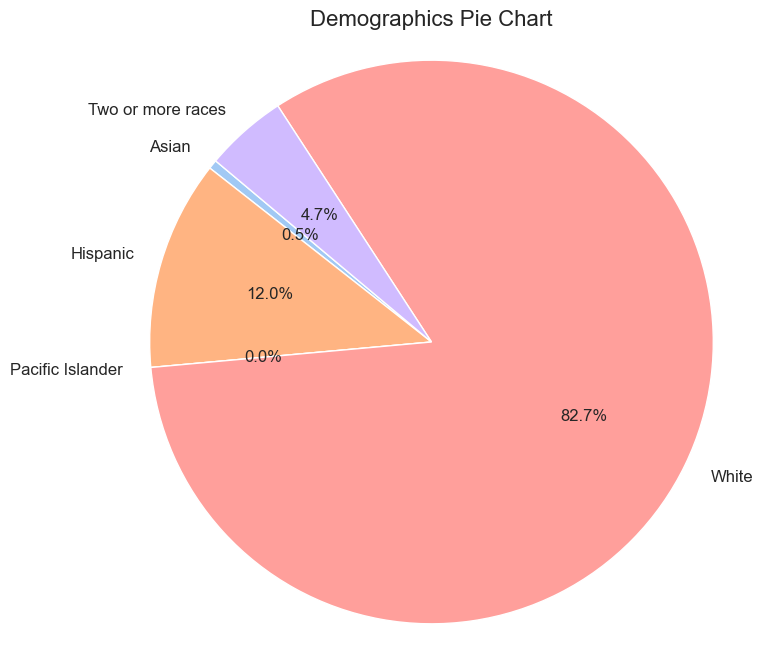

In [ ]:
# Retrieve data from MongoDB collection
data_from_mongodb = demog.find_one({}) 

# Prepare data for plotting
demographics_data = {
    'African American': data_from_mongodb.get('%_African_American', 0),
    'American Indian': data_from_mongodb.get('%_American_Indian', 0),
    'Asian': data_from_mongodb.get('%_Asian', 0),
    'Hispanic': data_from_mongodb.get('% Hispanic', 0),
    'Pacific Islander': data_from_mongodb.get('%_Pacific_Islander', 0),
    'White': data_from_mongodb.get('%_White', 0),
    'Two or more races': data_from_mongodb.get('%_Two_or_More_Races', 0)
}


# Filter out categories with 0%
demographics_data_filtered = {k: v for k, v in demographics_data.items() if v != 0}

# Adjusting pie chart parameters
colors = sns.color_palette('pastel')  # Use Seaborn's color palette
plt.figure(figsize=(8, 8))
plt.pie(
    demographics_data_filtered.values(),
    labels=demographics_data_filtered.keys(),
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}  # Adjust font size for better readability
)
plt.title('Demographics Pie Chart', fontsize=16)  # Adjust title font size
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()


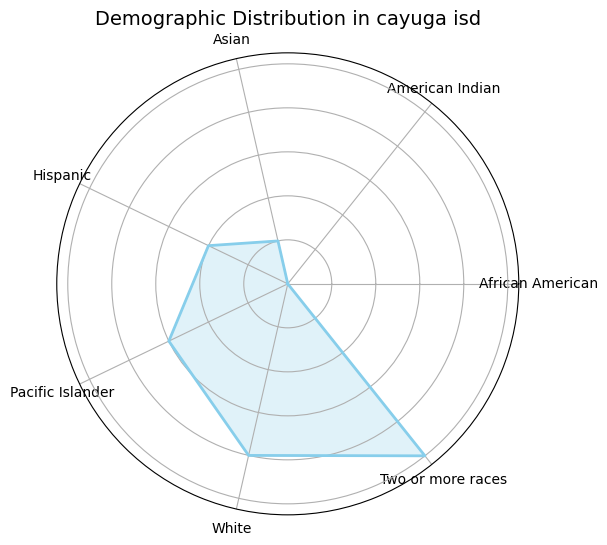

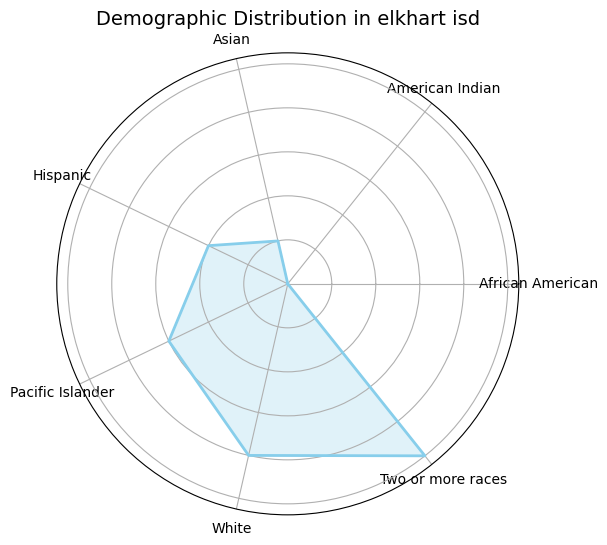

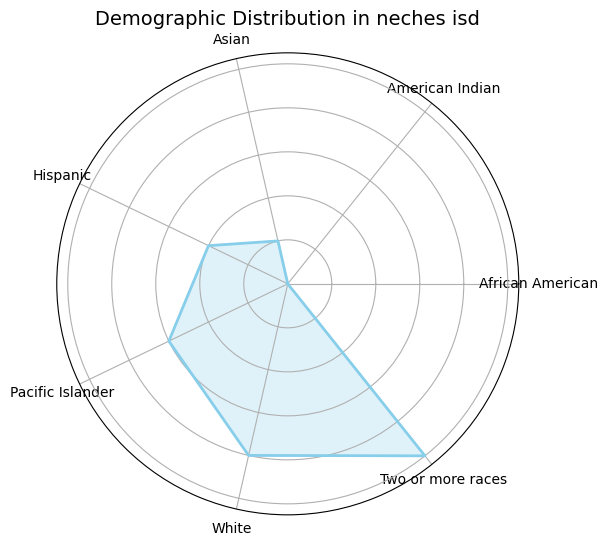

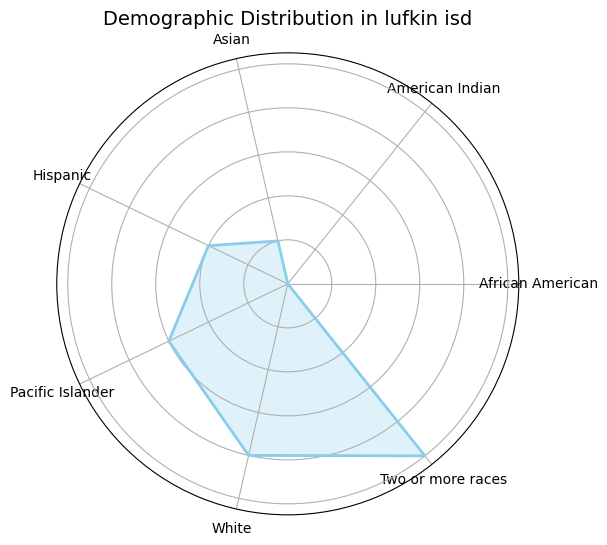

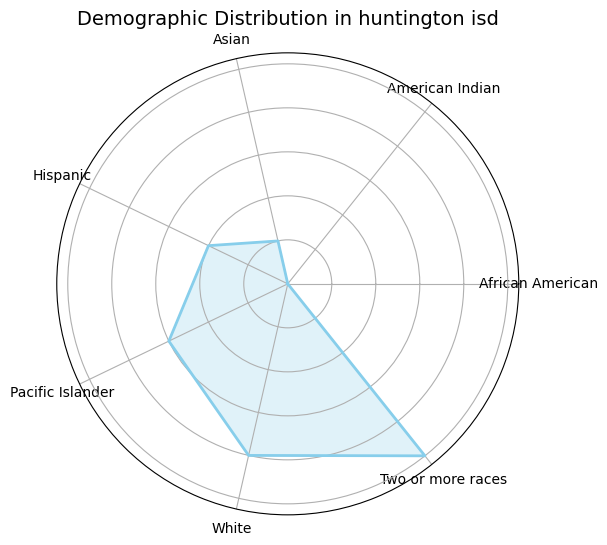

In [14]:

# Retrieve data from MongoDB collection
data_from_mongodb = demog.find({})  


# Example: Aggregate data by district
district_data = {}
for document in data_from_mongodb:
    African_American =  document.get('%_African_American', 0)
    American_Indian = document.get('%_American_Indian', 0)
    Asian = document.get('%_Asian', 0)
    Hispanic = document.get('% Hispanic', 0)
    Pacific_Islander =  document.get('%_Pacific_Islander', 0)
    White = document.get('%_White', 0)
    Two_or_more_races = document.get('%_Two_or_More_Races', 0)
    district = document.get('District_Name')
    
    if district not in district_data:
        district_data[district] = {
            'African American': African_American,
            'American Indian': American_Indian,
            'Asian': Asian,
            'Hispanic': Hispanic,
            'Pacific Islander': Pacific_Islander,
            'White': White,
            'Two or more races': Two_or_more_races
        }

# Generate comparative radar charts for each district (limit to the first 5 districts)
counter = 0
for district, demographics in district_data.items():
    if counter >= 5:
        break
    
    plt.figure(figsize=(8, 6))
    
    # Radar chart parameters
    labels = list(demographics.keys())
    values = list(demographics.values())
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop" and append the start at the end.
    values += values[:1]
    angles += angles[:1]

    # Plot
    ax = plt.subplot(111, polar=True)
    ax.fill(angles, values, color='skyblue', alpha=0.25)
    ax.plot(angles, values, color='skyblue', linewidth=2)  # Plotting the outline
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)  # Adjust font size of labels
    plt.title(f'Demographic Distribution in {district}', fontsize=14)  # Adjust title font size
    plt.show()
    counter += 1
    

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U50'), dtype('float64')) -> None

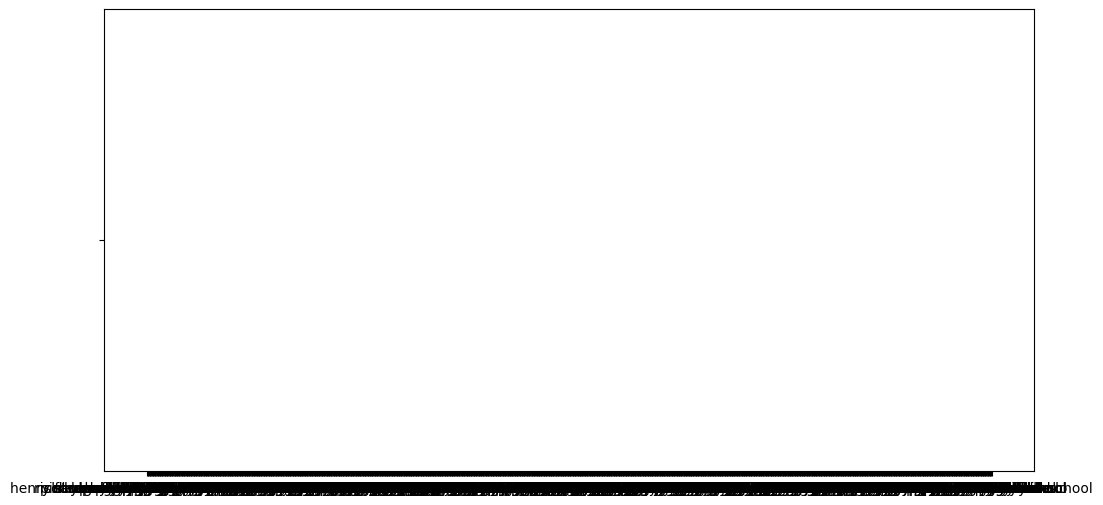

In [18]:
# Retrieve data from MongoDB
data_from_mongodb = demog.find({})

# Initialize lists to store demographic data
district_names = []
demographic_groups = ['%_African_American', '% Hispanic', '%_White', '%_American_Indian', '%_Asian', '%_Pacific_Islander', '%_Two_or_More_Races']
demographic_data = {group: [] for group in demographic_groups}

# Process data
for document in data_from_mongodb:
    district_names.append(document.get('District_Name'))
    for group in demographic_groups:
        value = document.get(group)
        if value is not None:
            demographic_data[group].append(float(value))
        else:
            demographic_data[group].append(0.0)  # Replace None with 0.0

# Plot the stacked bar chart
plt.figure(figsize=(12, 6))

# Convert lists to numpy arrays for easier manipulation
district_names = np.array(district_names, dtype=str)  # Convert district_names to string dtype
bottom = np.zeros_like(district_names)

for group in demographic_groups:
    values = np.array(demographic_data[group])
    plt.bar(district_names, values, label=group, bottom=bottom)
    bottom += values

# Add labels and titles
plt.xlabel('District Name')
plt.ylabel('Percentage')
plt.title('Stacked Bar Chart of Demographic Distribution')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Demographic Group')

# Show the plot
plt.tight_layout()
plt.show()